In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
# 데이터 로드, 날짜 데이터 변환
file_path = "./data/cluster_result.csv"  
dt = pd.read_csv(file_path, sep=',', encoding='utf-8', parse_dates=['DateTime'], infer_datetime_format=True)

C:\Users\doing\AppData\Local\Temp\ipykernel_19584\3297767452.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dt = pd.read_csv(file_path, sep=',', encoding='utf-8', parse_dates=['DateTime'], infer_datetime_format=True)


In [4]:
# 데이터 확인
print(dt.columns) 
print(dt.head(20))  
print(dt.info())  

Index(['Unnamed: 0', 'DateTime', 'USD', 'Effective Federal Funds Rate',
       'Government Bond 10Y', 'Interbank Rate', 'Interest Rate',
       'Stock Market', 'Auto Exports', 'Average House Prices',
       ...
       'Personal Income Tax Rate', 'Population', 'Precipitation',
       'Private Debt to GDP', 'Retirement Age Men', 'Retirement Age Women',
       'Temperature', 'Terrorism Index', 'Weapons Sales', 'kmeans_label'],
      dtype='object', length=259)
    Unnamed: 0   DateTime     USD  Effective Federal Funds Rate  \
0            0 2005-01-03  435.60                          2.31   
1            1 2005-01-04  427.75                          2.25   
2            2 2005-01-05  426.00                          2.25   
3            3 2005-01-06  424.35                          2.25   
4            4 2005-01-07  422.20                          2.24   
5            5 2005-01-10  420.00                          2.26   
6            6 2005-01-11  421.35                          2.24   
7 

In [5]:
# 불필요한 컬럼 제거 (kmeans_label, Unnamed: 0, DateTime)
dt_cleaned = dt.drop(['kmeans_label', 'Unnamed: 0'], axis=1)

In [6]:
# NaN 값이 포함된 컬럼과 NaN 개수 확인
nan_cnt = dt.isnull().sum()[dt.isnull().sum() > 0]
print("NaN 값이 포함된 컬럼과 NaN 개수:\n", nan_cnt)



NaN 값이 포함된 컬럼과 NaN 개수:
 Interbank Rate                    1
Housing Starts Single Family     21
CO2 Emissions                   260
Hospitals                       520
Hospital Beds                   520
Medical Doctors                 520
Nurses                          260
Precipitation                   260
Temperature                     260
dtype: int64


In [7]:
# NaN 값이 포함된 행 제거
df_cleaned = dt.dropna()

In [8]:
print("NaN 값이 포함된 컬럼 제거 후 컬럼별 NaN 개수:\n", df_cleaned.isnull().sum())

NaN 값이 포함된 컬럼 제거 후 컬럼별 NaN 개수:
 Unnamed: 0                      0
DateTime                        0
USD                             0
Effective Federal Funds Rate    0
Government Bond 10Y             0
                               ..
Retirement Age Women            0
Temperature                     0
Terrorism Index                 0
Weapons Sales                   0
kmeans_label                    0
Length: 259, dtype: int64


In [9]:
# 데이터 확인
print(dt_cleaned.columns) 
print(dt_cleaned.head(20))  
print(dt_cleaned.info())  

Index(['DateTime', 'USD', 'Effective Federal Funds Rate',
       'Government Bond 10Y', 'Interbank Rate', 'Interest Rate',
       'Stock Market', 'Auto Exports', 'Average House Prices',
       'Balance of Trade',
       ...
       'Nurses', 'Personal Income Tax Rate', 'Population', 'Precipitation',
       'Private Debt to GDP', 'Retirement Age Men', 'Retirement Age Women',
       'Temperature', 'Terrorism Index', 'Weapons Sales'],
      dtype='object', length=257)
     DateTime     USD  Effective Federal Funds Rate  Government Bond 10Y  \
0  2005-01-03  435.60                          2.31                4.218   
1  2005-01-04  427.75                          2.25                4.296   
2  2005-01-05  426.00                          2.25                4.285   
3  2005-01-06  424.35                          2.25                4.265   
4  2005-01-07  422.20                          2.24                4.273   
5  2005-01-10  420.00                          2.26                4.275   

In [10]:
# 데이터프레임에서 숫자형 데이터만 선택하여 날짜 컬럼 제외
dt_numeric = dt_cleaned.select_dtypes(include=[np.number])  # 숫자형 데이터만 선택 (날짜 컬럼 제외)

# 데이터 표준화
scaler = StandardScaler()
dt_scaled = scaler.fit_transform(dt_numeric) 

# numpy 배열을 pandas 데이터프레임으로 변환
df = pd.DataFrame(dt_scaled, columns=dt_numeric.columns)

# 표준화된 데이터 확인
print(df.head(10))

        USD  Effective Federal Funds Rate  Government Bond 10Y  \
0 -2.005333                      0.443456             1.251478   
1 -2.023919                      0.410445             1.321828   
2 -2.028062                      0.410445             1.311907   
3 -2.031969                      0.410445             1.293868   
4 -2.037059                      0.404943             1.301084   
5 -2.042268                      0.415947             1.302887   
6 -2.039071                      0.404943             1.274928   
7 -2.026641                      0.410445             1.269516   
8 -2.033744                      0.432452             1.205480   
9 -2.036349                      0.432452             1.253282   

   Interbank Rate  Interest Rate  Stock Market  Auto Exports  \
0        0.393423       0.352397     -0.909866     -1.417319   
1        0.396487       0.352397     -0.922758     -1.417319   
2        0.407241       0.352397     -0.926719     -1.417319   
3        0.417994

In [11]:
# 각 컬럼별 NaN 값 개수 확인
nan_per_column = df.isnull().sum()
print("각 컬럼의 NaN 값 개수:\n", nan_per_column[nan_per_column > 0])  # NaN 값이 있는 컬럼만 출력


각 컬럼의 NaN 값 개수:
 Interbank Rate                    1
Housing Starts Single Family     21
CO2 Emissions                   260
Hospitals                       520
Hospital Beds                   520
Medical Doctors                 520
Nurses                          260
Precipitation                   260
Temperature                     260
dtype: int64


In [12]:
# NaN 값이 포함된 행 제거
df_cleaned = df.dropna()

# NaN 값 제거 후 남아있는 데이터프레임의 상태 확인
print("NaN 값 제거 후 남은 행, 컬럼:", df_cleaned.shape)

df = df_cleaned


NaN 값 제거 후 남은 행, 컬럼: (4434, 256)


In [13]:
print(df.head(10))

        USD  Effective Federal Funds Rate  Government Bond 10Y  \
0 -2.005333                      0.443456             1.251478   
1 -2.023919                      0.410445             1.321828   
2 -2.028062                      0.410445             1.311907   
3 -2.031969                      0.410445             1.293868   
4 -2.037059                      0.404943             1.301084   
5 -2.042268                      0.415947             1.302887   
6 -2.039071                      0.404943             1.274928   
7 -2.026641                      0.410445             1.269516   
8 -2.033744                      0.432452             1.205480   
9 -2.036349                      0.432452             1.253282   

   Interbank Rate  Interest Rate  Stock Market  Auto Exports  \
0        0.393423       0.352397     -0.909866     -1.417319   
1        0.396487       0.352397     -0.922758     -1.417319   
2        0.407241       0.352397     -0.926719     -1.417319   
3        0.417994

# 컬럼이 너무 많아서, 분석시, 시각화시 어려움
-> 머신 러닝(랜덤 포레스트 회귀)를 통해 변수 중요도 계산을 해서 TOP20을 선정함

In [43]:
# 1. 데이터 준비: 설명 변수(X)와 목표 변수(y) 분리
X = df.drop(['USD', 'DBSCAN_Cluster'], axis=1)  # 금값(USD)과 군집 및 날짜 변수는 제거
y = df['USD']  # 금값을 목표 변수로 설정

In [44]:
# 2. 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X, y)

ValueError: could not convert string to float: 'High Value'

In [ ]:
# DBSCAN 군집화 적용
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(df)

In [15]:
# 군집화 결과 요약
unique_labels = set(clusters)
print(f"생성된 군집의 수: {len(unique_labels) - (1 if -1 in unique_labels else 0)}")  # -1은 노이즈를 의미하므로 군집 수에서 제외
print(f"노이즈 데이터의 개수: {(clusters == -1).sum()}")  # -1 레이블은 노이즈를 의미
print(f"각 군집에 속한 데이터의 개수: \n{pd.Series(clusters).value_counts()}")


생성된 군집의 수: 205
노이즈 데이터의 개수: 6
각 군집에 속한 데이터의 개수: 
 204    23
 94     23
 33     23
 109    23
 187    23
        ..
 148    20
 182    19
 36     14
 37      8
-1       6
Name: count, Length: 206, dtype: int64


In [16]:
# 결과를 원본 데이터에 추가
df['DBSCAN_Cluster'] = clusters

In [17]:
# 군집의 수 및 이상치 수 계산
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
num_outliers = list(clusters).count(-1)
print(f"Number of clusters found: {num_clusters}")
print(f"Number of outliers: {num_outliers}")

Number of clusters found: 205
Number of outliers: 6


In [18]:
# 실루엣 계수 계산
score = silhouette_score(df, clusters)
print(f"실루엣 계수: {score:.3f}")

실루엣 계수: 0.977


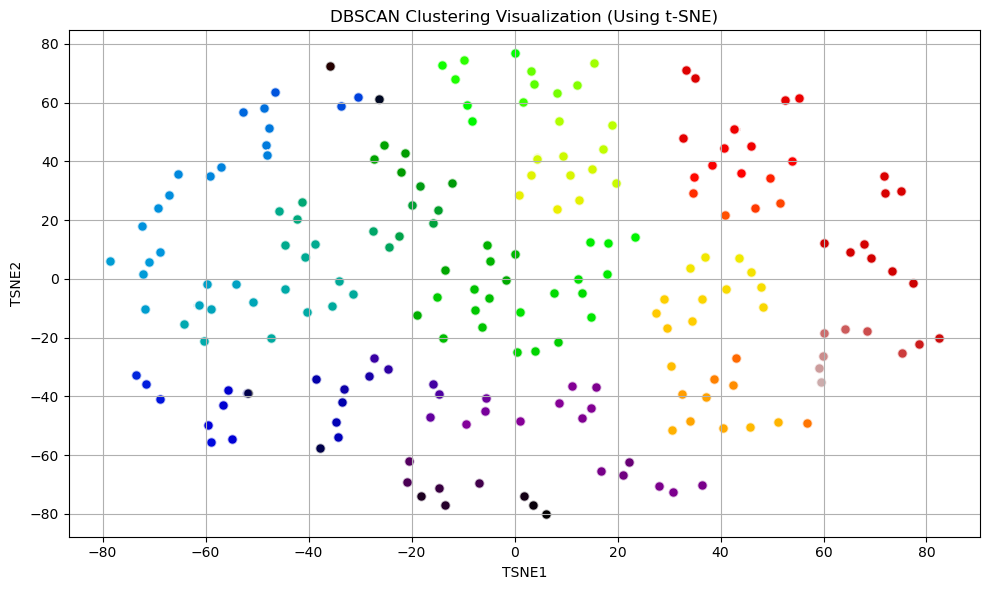

In [19]:
# t-SNE를 사용하여 데이터 차원 축소 (고차원 데이터를 2차원으로 변환)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df.iloc[:, :-1])  # 'DBSCAN_Cluster' 컬럼 제외

# t-SNE 결과를 새로운 데이터프레임으로 변환
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters  # DBSCAN 클러스터 레이블 추가

# t-SNE로 변환된 2차원 데이터를 사용하여 시각화
plt.figure(figsize=(10, 6))
for cluster in set(clusters):
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
    if cluster == -1:
        color = 'black'
        label = 'Outliers'
    else:
        color = plt.cm.nipy_spectral(float(cluster) / len(set(clusters)))
        label = f'Cluster {cluster}'

    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], s=50, c=[color], label=label, alpha=0.6, edgecolors='w')

plt.title('DBSCAN Clustering Visualization (Using t-SNE)')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout() 
plt.show()


In [20]:
# PCA를 사용하여 2차원으로 차원 축소
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df)

C:\Users\doing\AppData\Local\Temp\ipykernel_19584\520741259.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_clusters))  # 색상맵 지정


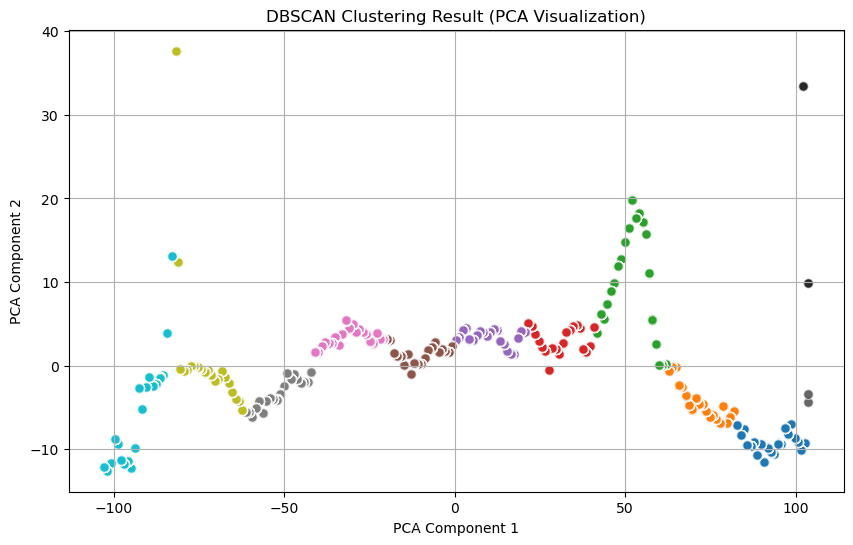

In [21]:
# PCA 시각화
plt.figure(figsize=(10, 6))
unique_clusters = set(clusters)
colors = plt.cm.get_cmap('tab10', len(unique_clusters))  # 색상맵 지정

for cluster in unique_clusters:
    # 각각의 클러스터 색상과 라벨 지정
    if cluster == -1:
        color = 'black'
        label = 'Outliers'
    else:
        color = colors(cluster)
        label = f'Cluster {cluster}'
    
    plt.scatter(data_pca[clusters == cluster, 0], data_pca[clusters == cluster, 1], 
                s=50, c=[color], label=label, alpha=0.6, edgecolors='w')

# 그래프 제목과 축 설정
plt.title('DBSCAN Clustering Result (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# plt.legend()
plt.grid(True)
plt.show()

# 군집별 주요 변수의 평균값 및 통계량 분석
군집별 평균값을 비교하여 각 군집이 어떤 변수에서 높은 값 또는 낮은 값을 가지는지 파악.
히트맵을 통해 변수의 값을 시각적으로 비교하여, 군집 간의 특성을 한눈에 확인.

In [23]:
# 군집별 평균값 계산
cluster_summary = df.groupby('DBSCAN_Cluster').mean()
print("Cluster Summary (Mean Values):\n", cluster_summary)

Cluster Summary (Mean Values):
                      USD  Effective Federal Funds Rate  Government Bond 10Y  \
DBSCAN_Cluster                                                                
-1             -0.343145                      0.194040            -0.104459   
 0             -2.031422                      0.434810             1.243919   
 1             -2.034336                      0.546064             1.206021   
 2             -2.010248                      0.619274             1.504957   
 3             -2.020407                      0.699945             1.348800   
...                  ...                           ...                  ...   
 200            1.188695                     -0.776195            -1.400095   
 201            1.171228                     -0.783948            -1.317725   
 202            1.170287                     -0.783709            -1.131318   
 203            1.272994                     -0.783698            -1.147511   
 204            1.20

In [24]:
# 군집별 통계량 계산
cluster_stats = df.groupby('DBSCAN_Cluster').describe()
print("Cluster Statistics (Summary):\n", cluster_stats)

Cluster Statistics (Summary):
                  USD                                                    \
               count      mean       std       min       25%       50%   
DBSCAN_Cluster                                                           
-1               6.0 -0.343145  1.037914 -1.062653 -1.037941 -0.962324   
 0              21.0 -2.031422  0.007818 -2.042268 -2.036941 -2.031969   
 1              20.0 -2.034336  0.018503 -2.063340 -2.050910 -2.033626   
 2              23.0 -2.010248  0.014985 -2.030074 -2.025753 -2.011488   
 3              21.0 -2.020407  0.010332 -2.034099 -2.028654 -2.024510   
...              ...       ...       ...       ...       ...       ...   
 200            22.0  1.188695  0.064332  1.043607  1.166251  1.195847   
 201            22.0  1.171228  0.067646  1.068230  1.109842  1.178267   
 202            21.0  1.170287  0.041247  1.114281  1.135353  1.161752   
 203            22.0  1.272994  0.080037  1.138549  1.204459  1.249296   
 204   

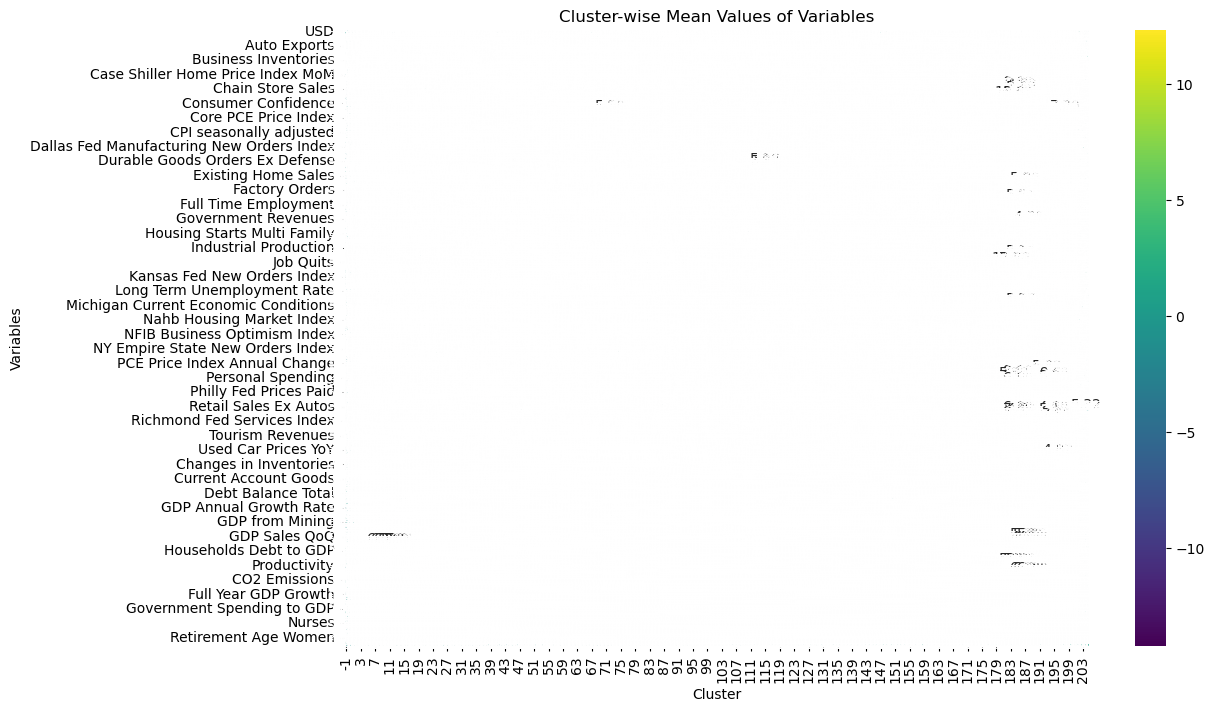

In [40]:
# 군집별 평균값 시각화 (예시: 히트맵으로 표시)
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_summary.T, cmap='viridis', annot=True, fmt='.2f')
plt.title('Cluster-wise Mean Values of Variables')
plt.xlabel('Cluster')
plt.ylabel('Variables')
plt.show()

박스 플롯이나 히스토그램을 통해 군집별 변수의 분포를 확인하여, 각 군집이 해당 변수에서 어떤 특성을 가지는지 파악.
예를 들어, 금리나 주식시장 지수와 같은 변수의 값이 특정 군집에서 어떻게 분포되어 있는지를 시각적으로 확인.

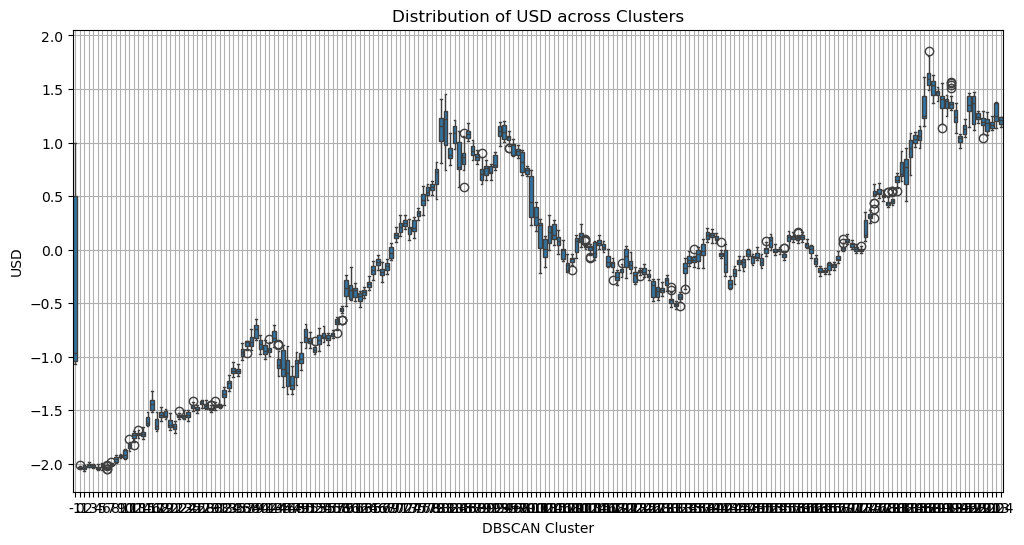

In [ ]:
# 특정 변수의 군집별 분포 시각화 (박스 플롯)
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(x='DBSCAN_Cluster', y='USD', data=df)  # 예시: 'USD' 변수를 군집별로 비교
plt.title('Distribution of USD across Clusters')
plt.xlabel('DBSCAN Cluster')
plt.ylabel('USD')
plt.grid(True)
plt.show()

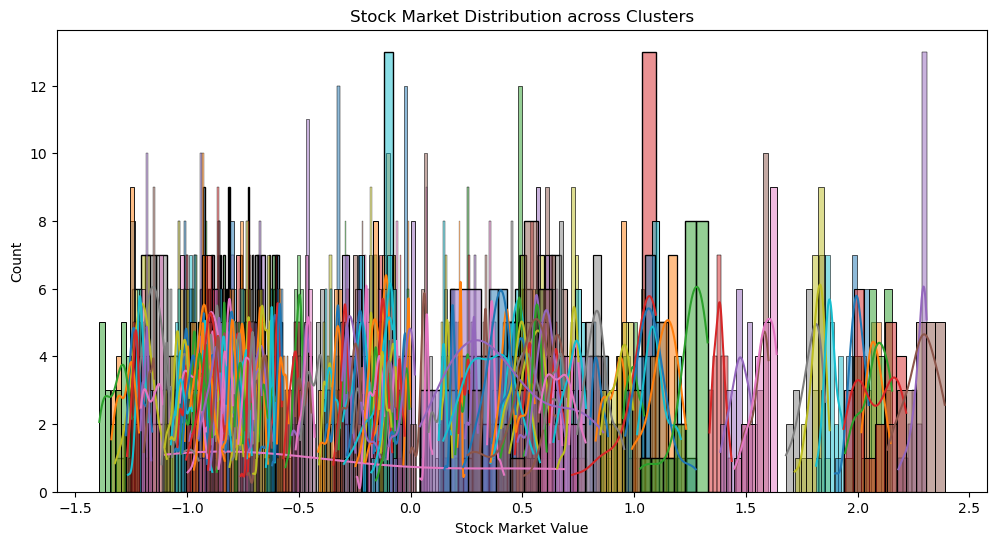

In [28]:
# 특정 변수의 군집별 히스토그램 (예: 'Stock Market' 변수)
plt.figure(figsize=(12, 6))
for cluster in df['DBSCAN_Cluster'].unique():
    sns.histplot(df[df['DBSCAN_Cluster'] == cluster]['Stock Market'], label=f'Cluster {cluster}', kde=True)
plt.title('Stock Market Distribution across Clusters')
plt.xlabel('Stock Market Value')
plt.show()

# 군집의 대표 데이터 포인트 찾기
각 군집의 **중심(centroid)**에 가장 가까운 데이터를 찾아서, 각 군집의 대표적인 데이터 포인트를 확인. 
이를 통해 각 군집의 대표적인 특성을 파악.

각 군집의 대표적인 데이터 포인트를 확인하여, 군집의 대표적인 특성을 이해하고 군집의 중심에 위치한 데이터가 어떤 특성을 가지는지 파악

In [29]:
from sklearn.metrics import pairwise_distances_argmin_min

In [30]:
# 군집의 중심(centroid) 계산
centroids = df.groupby('DBSCAN_Cluster').mean().values  # 각 군집의 중심 좌표

In [31]:
# 각 군집의 중심에 가장 가까운 데이터 포인트 찾기
closest, _ = pairwise_distances_argmin_min(centroids, df.drop(['DBSCAN_Cluster'], axis=1).values)

In [32]:
# 대표 데이터 포인트 출력
representative_points = df.iloc[closest]
print("Representative points for each cluster:\n", representative_points)

Representative points for each cluster:
            USD  Effective Federal Funds Rate  Government Bond 10Y  \
980  -0.963804                      0.250892             0.568722   
10   -2.036941                      0.432452             1.244262   
32   -2.034928                      0.536986             1.199166   
50   -1.990298                      0.597506             1.520251   
73   -2.034099                      0.707542             1.341670   
...        ...                           ...                  ...   
4336  1.200108                     -0.772444            -1.418215   
4354  1.212302                     -0.783447            -1.343356   
4379  1.160332                     -0.783447            -1.131404   
4405  1.263088                     -0.783447            -1.087209   
4427  1.208040                     -0.783447            -1.237831   

      Interbank Rate  Interest Rate  Stock Market  Auto Exports  \
980         1.320570       0.212191     -1.043286      0.114201

# 군집 간의 상관관계 분석
군집 간의 상관관계를 분석하여, 군집화된 데이터가 서로 어떤 관계를 가지는지 파악. 
예를 들어, 특정 변수(금리, 주식시장 지수 등)와 군집 결과 간의 상관관계를 확인.

상관관계 히트맵을 통해 군집 간의 변수들이 어떤 상관관계를 가지는지 확인.
예를 들어, 특정 군집이 주식시장 지수와 높은 상관관계를 가지는지, 금리와 인플레이션 간의 상관관계가 군집별로 어떻게 다른지 분석.

In [33]:
# 군집과 특정 변수 간의 상관관계 분석
correlation_matrix = df.groupby('DBSCAN_Cluster').mean().corr()
print("Correlation Matrix of Cluster-wise Mean Values:\n", correlation_matrix)

Correlation Matrix of Cluster-wise Mean Values:
                                    USD  Effective Federal Funds Rate  \
USD                           1.000000                     -0.715260   
Effective Federal Funds Rate -0.715260                      1.000000   
Government Bond 10Y          -0.878237                      0.757639   
Interbank Rate               -0.748888                      0.980531   
Interest Rate                -0.706099                      0.997745   
...                                ...                           ...   
Retirement Age Men            0.376597                     -0.182051   
Retirement Age Women          0.376597                     -0.182051   
Temperature                   0.255697                     -0.036225   
Terrorism Index               0.284733                     -0.279517   
Weapons Sales                 0.647835                     -0.368014   

                              Government Bond 10Y  Interbank Rate  \
USD              

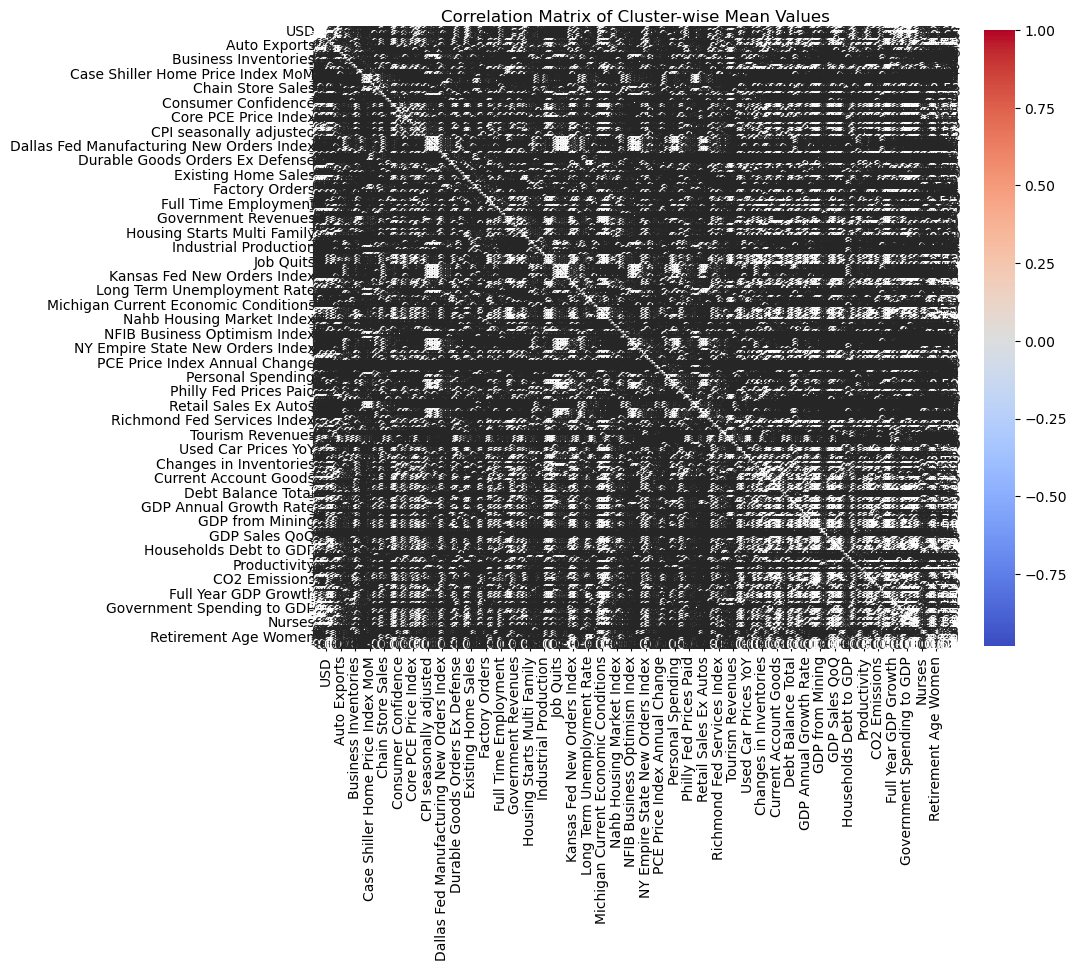

In [34]:
# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Cluster-wise Mean Values')
plt.show()

# 군집별로 라벨링 및 추가 해석
군집의 특성을 바탕으로 군집에 라벨을 부여하여, 군집에 대한 해석을 시도. 
예를 들어, 고객 데이터라면 "고가 상품 선호 고객", "가격 민감 고객" 등으로 군집을 명명.

각 군집의 특성에 따라 라벨을 부여하고, 각 군집이 어떤 특성을 가지는지 이해.
라벨을 부여한 후, 각 군집이 라벨에 맞게 잘 분포되어 있는지 시각적으로 확인.

In [35]:
# 각 군집에 대한 간단한 라벨링 예시 (필요에 따라 수정 가능)
cluster_labels = {0: 'High Value', 1: 'Medium Value', 2: 'Low Value'}  # 예시 라벨
df['Cluster_Label'] = df['DBSCAN_Cluster'].map(cluster_labels)  # DBSCAN 군집 결과를 라벨링

In [36]:
# 군집별 라벨링 결과 확인
print("Cluster Label Summary:\n", df['Cluster_Label'].value_counts())

Cluster Label Summary:
 Cluster_Label
Low Value       23
High Value      21
Medium Value    20
Name: count, dtype: int64


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# 1. t-SNE 수행 및 결과를 데이터프레임에 추가 (이미 t-SNE가 수행되지 않았을 경우)
if 'TSNE1' not in df.columns or 'TSNE2' not in df.columns:
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(df.drop(['DBSCAN_Cluster', 'Cluster_Label'], axis=1, errors='ignore'))
    df['TSNE1'] = tsne_results[:, 0]
    df['TSNE2'] = tsne_results[:, 1]

# 2. Cluster_Label 컬럼이 없는 경우 임시로 DBSCAN_Cluster를 문자열로 변환하여 추가
if 'Cluster_Label' not in df.columns:
    df['Cluster_Label'] = df['DBSCAN_Cluster'].astype(str)

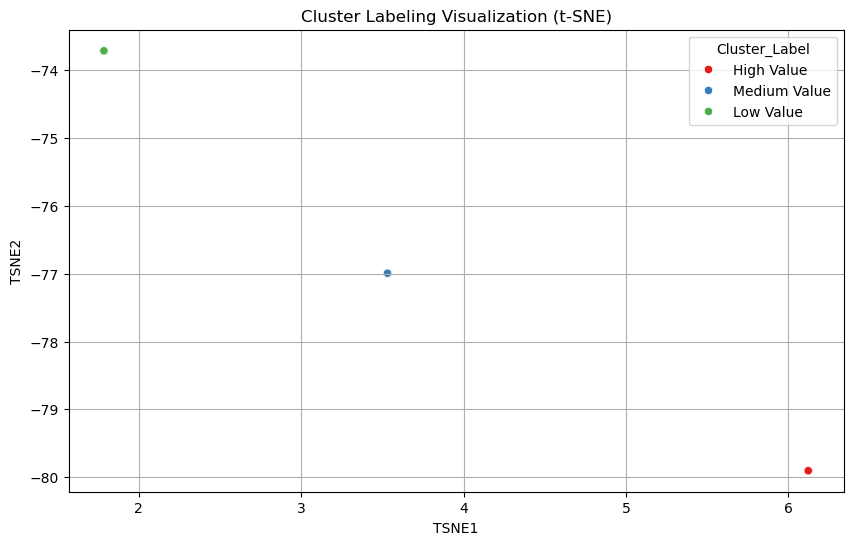

In [39]:
# 3. 군집별 라벨링된 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster_Label', data=df, palette='Set1')
plt.title('Cluster Labeling Visualization (t-SNE)')
plt.grid(True)
plt.show()